Pre spiltted folders

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

img_size = 224
batch_size = 16

# Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    r"C:\Users\KIIT\Desktop\VS_Code\GitHub\Major_Project\data\Ultrasound Fetus Dataset\train",
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = test_val_datagen.flow_from_directory(
    r"C:\Users\KIIT\Desktop\VS_Code\GitHub\Major_Project\data\Ultrasound Fetus Dataset\validation",
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_val_datagen.flow_from_directory(
    r"C:\Users\KIIT\Desktop\VS_Code\GitHub\Major_Project\data\Ultrasound Fetus Dataset\test",
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 1926 images belonging to 3 classes.
Found 341 images belonging to 3 classes.
Found 401 images belonging to 3 classes.


my split

In [3]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = r"C:\Users\KIIT\Desktop\VS_Code\GitHub\Major_Project\data\Ultrasound Fetus Dataset\Datasets"
img_size = 224
batch_size = 16

rows = []
for cls in os.listdir(base_dir):
    cls_path = os.path.join(base_dir, cls)
    if not os.path.isdir(cls_path):
        continue
    for fname in os.listdir(cls_path):
        fpath = os.path.join(cls_path, fname)
        rows.append({"filepath": fpath, "class": cls})

df = pd.DataFrame(rows)
train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df["class"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["class"], random_state=42)

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(train_df, x_col="filepath", y_col="class",
                                                    target_size=(img_size, img_size), batch_size=batch_size,
                                                    class_mode="categorical", shuffle=True)

val_generator = val_test_datagen.flow_from_dataframe(val_df, x_col="filepath", y_col="class",
                                                     target_size=(img_size, img_size), batch_size=batch_size,
                                                     class_mode="categorical", shuffle=False)

test_generator = val_test_datagen.flow_from_dataframe(test_df, x_col="filepath", y_col="class",
                                                      target_size=(img_size, img_size), batch_size=batch_size,
                                                      class_mode="categorical", shuffle=False)


Found 2075 validated image filenames belonging to 3 classes.
Found 444 validated image filenames belonging to 3 classes.
Found 445 validated image filenames belonging to 3 classes.


C:\Users\KIIT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  warnings.warn(
C:\Users\KIIT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  warnings.warn(


In [4]:
set_train = set(train_generator.filenames)
set_val = set(val_generator.filenames)
set_test = set(test_generator.filenames)

total_unique = len(set_train.union(set_val).union(set_test))
print("train", len(set_train))
print("val", len(set_val))
print("test", len(set_test))
print("unique across all generators", total_unique)


train 2075
val 444
test 445
unique across all generators 2964


In [5]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
output = Dense(3, activation='softmax')(x)  # 3 classes

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,113,027 (91.98 MB)

 Trainable params: 525,315 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

weighted balancing

In [6]:
epochs = 5

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)


C:\Users\KIIT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.6458 - loss: 0.9206 - val_accuracy: 0.7477 - val_loss: 0.7351
Epoch 2/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.7472 - loss: 0.7345 - val_accuracy: 0.7477 - val_loss: 0.6445
Epoch 3/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.7415 - loss: 0.6872 - val_accuracy: 0.7477 - val_loss: 0.6371
Epoch 4/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.7320 - loss: 0.6991 - val_accuracy: 0.7477 - val_loss: 0.6221
Epoch 5/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.7397 - loss: 0.6799 - val_accuracy: 0.7432 - val_loss: 0.6132


In [7]:
# Evaluate on test set (uses the existing `model` and `test_generator`)
loss, acc = model.evaluate(test_generator, verbose=1)
print("Test loss: {:.4f}".format(loss))
print("Test accuracy: {:.4f}".format(acc))

C:\Users\KIIT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


28/28 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7339 - loss: 0.5996
Test loss: 0.6153
Test accuracy: 0.7416


In [8]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Predict on test set
y_probs = model.predict(test_generator)
y_pred = np.argmax(y_probs, axis=1)

y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Metrics
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, average='weighted'))
print("Recall:", recall_score(y_true, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_true, y_pred, average='weighted'))

# Detailed report
print(classification_report(y_true, y_pred, target_names=class_labels))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


28/28 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step
Accuracy: 0.7415730337078652
Precision: 0.5528393562101427
Recall: 0.7415730337078652
F1 Score: 0.6334469010511055
              precision    recall  f1-score   support

      benign       0.00      0.00      0.00        59
   malignant       0.74      1.00      0.85       331
      normal       0.00      0.00      0.00        55

    accuracy                           0.74       445
   macro avg       0.25      0.33      0.28       445
weighted avg       0.55      0.74      0.63       445

Confusion Matrix:
 [[  0  59   0]
 [  1 330   0]
 [  0  55   0]]


C:\Users\KIIT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\KIIT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\KIIT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classif

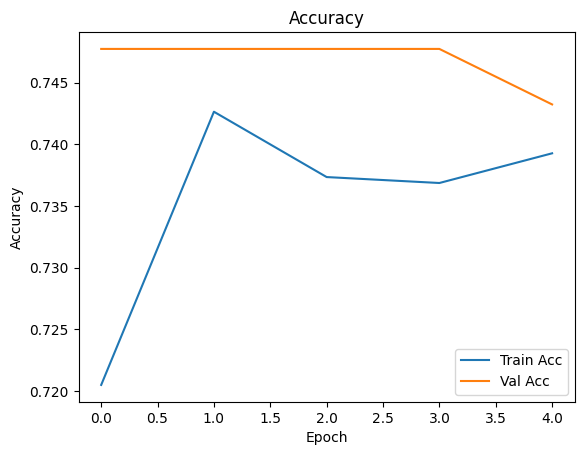

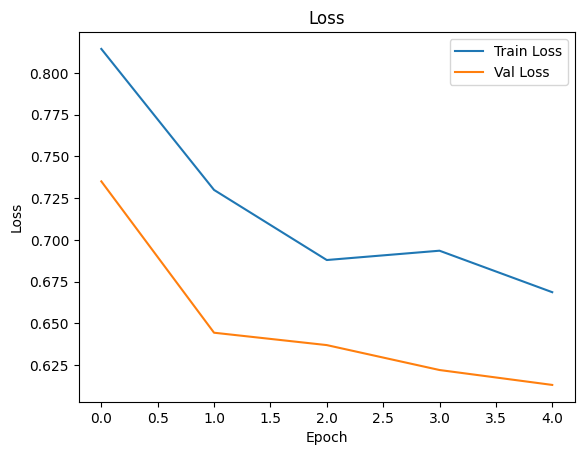

In [9]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [10]:
model.save(r'C:\Users\KIIT\Desktop\VS_Code\GitHub\Major_Project\model_artifacts\fetal_ultrasound_classifier.h5')